# kNN Classification Guide

## How to Use the Code

### Step 1: Load Necessary Functions
Ensure the following functions are loaded in your notebook:
- `initData`: Initialize and split the dataset
- `minkowski_distance`: Calculate distance between points
- `knn`: Perform k-Nearest Neighbors classification
- `compute_accuracy`: Calculate model accuracy
- `plot_decision_map`: Visualize decision boundaries

### Step 2: Initialize the Data
1. Set the file path to your dataset:
   ```python
   dataset_file = 'path/to/updated_pollution_dataset.csv'
2. Define the attributes you want to use:
    attributes = ['Temperature', 'SO2']  # Choose any two attributes
3. Set the parameters for kNN:
    k = 6  # Number of neighbors
    p = 4  # Minkowski distance parameter
    grid_step = 0.1  # step for visualisation
4. Define the split ratios:
    training_ratio = 0.7
    validation_ratio = 0.2
    test_ratio = 0.1  # Ennsure the sum of ratio is 1
5. Load and split the data:
    chosen_header, training_data, validation_data, test_data, labels = initData(
        filename=dataset_file,
        training_ratio=training_ratio,
        validation_ratio=validation_ratio,
        test_ratio=test_ratio,
        attributes=attributes
    )
### Step 3: Use Necessary Features
1. Classify Sample Data: 
    Select a random point from the test data:
    Calculate distances to all points in the training set and find the first k neighbors:
    Predict the label based on the neighbors:
    Calculate the vote of each label among the k neighbors:
2. Plot the Decision Map:
    Visualize the decision boundaries
    plot_decision_map(training_data, attributes, k, p, grid_step)

In [258]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


In [259]:

# Initialize the data
def initData(filename, training_ratio, validation_ratio, test_ratio, attributes):
    with open(filename, 'r', newline='') as file:
        file_csv = csv.reader(file)
        full_header = next(file_csv)  # Read the full header row

        # Identify indices for the chosen attributes
        chosen_indices = [full_header.index(attr) for attr in attributes]
        labels = []
        data = []

        for row in file_csv:
            if len(row) < len(full_header):
                continue
            
            # Extract chosen attributes and convert to float
            features = [float(row[i]) for i in chosen_indices]
            
            # Assume the last column is the label
            label = row[-1]
            data.append(features + [label])
            
            if label not in labels:
                labels.append(label)

        len_data = len(data)
        print(f"Total rows read: {len_data}")

        # Split into training, validation, and test sets
        train_idx = int(training_ratio * len_data)
        val_idx = int((training_ratio + validation_ratio) * len_data)
        
        training_data = data[:train_idx]
        validation_data = data[train_idx:val_idx]
        test_data = data[val_idx:]

        if len(training_data) == 0 or len(validation_data) == 0:
            print("[ERROR] Training or validation set is empty. Check your data split.")
            exit()
    
    chosen_header = [full_header[i] for i in chosen_indices]
    return chosen_header, training_data, validation_data, test_data, labels


In [260]:
def minkowski_distance(point_1, point_2, p):
    return sum(abs(a - b)**p for a, b in zip(point_1, point_2))**(1/p)


In [261]:
def knn(training_data, new_point, k, p):
    distances = [
        (minkowski_distance(new_point, row[:-1], p), row[-1])
        for row in training_data
    ]
    distances.sort(key=lambda x: x[0])
    
    # Perform voting among the k nearest neighbors
    votes = {}
    for i in range(k):
        label = distances[i][1]
        votes[label] = votes.get(label, 0) + 1
    
    return max(votes, key=votes.get)

In [262]:
def compute_accuracy(training_data, data, k, p):

    if not data:
        return 0
    correct = sum(
        knn(training_data, point[:-1], k, p) == point[-1]
        for point in data
    )
    return correct / len(data)


In [263]:
def plot_decision_map(training_data, attributes, k, p, grid_step):
    print("[DEBUG] Generating decision map... This can take time if the range is large.")
    
    # Extract x, y, and labels from the training data
    x_vals = [row[0] for row in training_data]
    y_vals = [row[1] for row in training_data]
    data_labels = [row[-1] for row in training_data]
    
    # Define the plot range
    x_min, x_max = min(x_vals) - 1, max(x_vals) + 1
    y_min, y_max = min(y_vals) - 1, max(y_vals) + 1
    
    # Generate a grid of points for the decision map
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, grid_step),
        np.arange(y_min, y_max, grid_step)
    )
    
    # Classify each grid point
    Z = np.array([
        knn(training_data, [mx, my], k, p)
        for mx, my in zip(xx.ravel(), yy.ravel())
    ]).reshape(xx.shape)
    
    # Map labels to integers for coloring
    unique_labels = sorted(set(data_labels))
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    color_map = ListedColormap(colors)
    label_to_idx = {lab: idx for idx, lab in enumerate(unique_labels)}
    Z_int = np.vectorize(label_to_idx.get)(Z)
    
    # Plot decision regions
    fig, ax = plt.subplots(figsize=(10, 6))
    contour = ax.pcolormesh(
        xx, yy, Z_int,
        cmap=color_map, alpha=0.2, shading='auto'
    )
    
    # Plot training points
    for label in unique_labels:
        mask = [row[-1] == label for row in training_data]
        x = [row[0] for row, m in zip(training_data, mask) if m][:100]
        y = [row[1] for row, m in zip(training_data, mask) if m][:100]
        ax.scatter(
            x, y,
            c=[color_map(label_to_idx[label])],
            label=label,
            edgecolor='black', linewidth=0.1,
            s=10
        )
    
    # Labels, title, and legend
    ax.set_xlabel(attributes[0], fontsize=12)
    ax.set_ylabel(attributes[1], fontsize=12)
    ax.set_title(f"Decision Boundaries: {attributes[0]} vs {attributes[1]}", fontsize=14, pad=15)
    ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Save and display the figure
    plt.tight_layout()
    out_filename = f"{attributes[0]}_{attributes[1]}.png"
    plt.savefig(out_filename, dpi=300, bbox_inches='tight')
    print(f"[DEBUG] Decision map saved as '{out_filename}'")
    
    plt.show()
    plt.close()

In [264]:
dataset_file = 'final_pollution_dataset.csv'
attributes = ['NO2','CO', 'Proximity_to_Industrial_Areas'] 
k = 15
p = 3
grid_step = 0.05  # Grid step size for faster computation

# Split ratios
training_ratio = 0.7
validation_ratio = 0.1
test_ratio = 0.2

# Load data
chosen_header, training_data, validation_data, test_data, labels = initData(
    filename=dataset_file,
    training_ratio=training_ratio,
    validation_ratio=validation_ratio,
    test_ratio=test_ratio,
    attributes=attributes
)

Total rows read: 5000


In [265]:
import random

# Choose a sample point to demonstrate the classification process
# input: a random point in the validation set, the corresponding attribute values
# output: first k neighbors and the predicted label
#         the vote of each label among the k neighbors
#         Hence the predicted label

# Select a random point from the validation set
#sample_point = random.choice(test_data)
sample_point = test_data[729]
print(f"Sample point: {sample_point}")

# Calculate distances to all points in the training set
neighbors = [
    (minkowski_distance(sample_point[:-1], row[:-1], p), row[-1])
    for row in training_data
]

# Sort and select the first k neighbors
neighbors.sort(key=lambda x: x[0])
first_k_neighbors = neighbors[:k]
print(f"First {k} neighbors: {first_k_neighbors}")

# Predict the label based on the neighbors
predicted_label = knn(training_data, sample_point[:-1], k, p)
print(f"Predicted label: {predicted_label}")

# Calculate the vote of each label among the k neighbors
votes = {}
for distance, label in first_k_neighbors:
    votes[label] = votes.get(label, 0) + 1

print(f"Votes: {votes}")

Sample point: [39.7, 1.83, 11.5, 'Poor']
First 15 neighbors: [(1.0400616334282193, 'Hazardous'), (1.046763123263883, 'Poor'), (1.3851576582029317, 'Hazardous'), (1.4375304895864565, 'Moderate'), (1.4608569123572404, 'Hazardous'), (1.4826809514590058, 'Poor'), (1.6737256513430336, 'Hazardous'), (1.8866176921003983, 'Poor'), (2.0239409388734817, 'Hazardous'), (2.0652252899067625, 'Poor'), (2.1217967886896103, 'Hazardous'), (2.1383660774499584, 'Poor'), (2.34018845731791, 'Hazardous'), (2.516711086936282, 'Poor'), (2.541851265758694, 'Poor')]
Predicted label: Hazardous
Votes: {'Hazardous': 7, 'Poor': 7, 'Moderate': 1}


In [266]:
# Accuracy before scale
# Compute accuracy
acc_val = compute_accuracy(training_data, validation_data, k, p)
acc_test = compute_accuracy(training_data, test_data, k, p)
print(f"Validation accuracy: {acc_val:.3f}")
print(f"Test accuracy: {acc_test:.3f}")

Validation accuracy: 0.868
Test accuracy: 0.837


In [267]:
# Scale the data

from sklearn.preprocessing import StandardScaler
import numpy as np

def scale_data(training_data, validation_data, test_data):
    """
    Scale features using StandardScaler while preserving labels
    """
    # Extract features and labels
    train_features = np.array([row[:-1] for row in training_data])
    val_features = np.array([row[:-1] for row in validation_data])
    test_features = np.array([row[:-1] for row in test_data])
    
    # Get labels
    train_labels = [row[-1] for row in training_data]
    val_labels = [row[-1] for row in validation_data]
    test_labels = [row[-1] for row in test_data]
    
    # Scale features
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_features)
    val_scaled = scaler.transform(val_features)
    test_scaled = scaler.transform(test_features)
    
    # Combine scaled features with labels
    training_scaled = [list(features) + [label] for features, label in zip(train_scaled, train_labels)]
    validation_scaled = [list(features) + [label] for features, label in zip(val_scaled, val_labels)]
    test_scaled = [list(features) + [label] for features, label in zip(test_scaled, test_labels)]
    
    return training_scaled, validation_scaled, test_scaled

# Add this after data loading in main():
training_data, validation_data, test_data = scale_data(training_data, validation_data, test_data)

In [268]:
# Compute accuracy AFTER scaling
acc_val = compute_accuracy(training_data, validation_data, k, p)
acc_test = compute_accuracy(training_data, test_data, k, p)
print(f"Validation accuracy AFTER SCALE: {acc_val:.3f}")
print(f"Test accuracy AFTER SCALE: {acc_test:.3f}")

Validation accuracy AFTER SCALE: 0.926
Test accuracy AFTER SCALE: 0.907


3D plot
[DEBUG] Generating decision map... This can take time if the range is large.
[DEBUG] Decision map saved as 'NO2_CO.png'


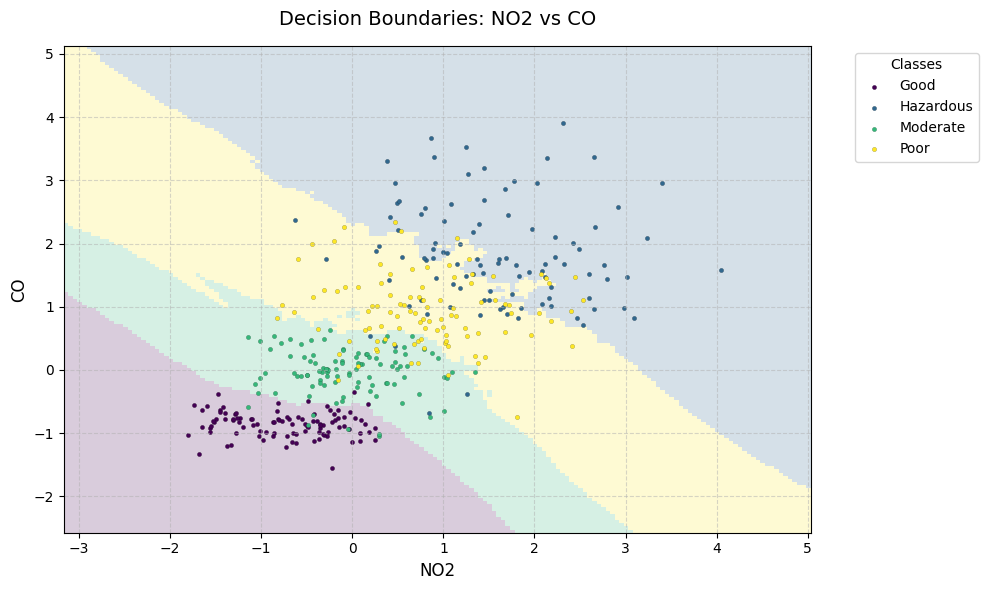

[DEBUG] Generating decision map... This can take time if the range is large.
[DEBUG] Decision map saved as 'CO_Proximity_to_Industrial_Areas.png'


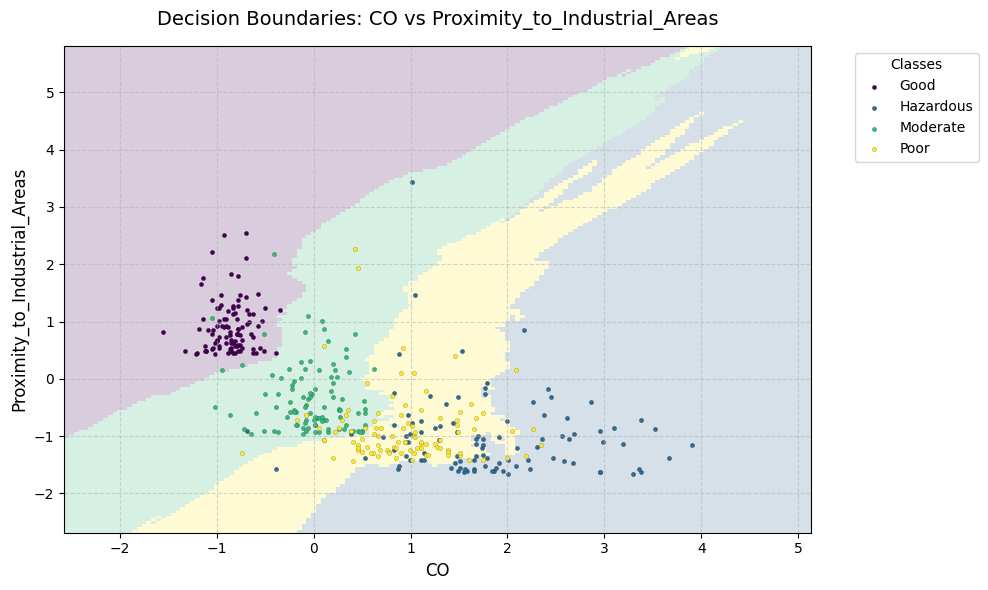

[DEBUG] Generating decision map... This can take time if the range is large.
[DEBUG] Decision map saved as 'NO2_Proximity_to_Industrial_Areas.png'


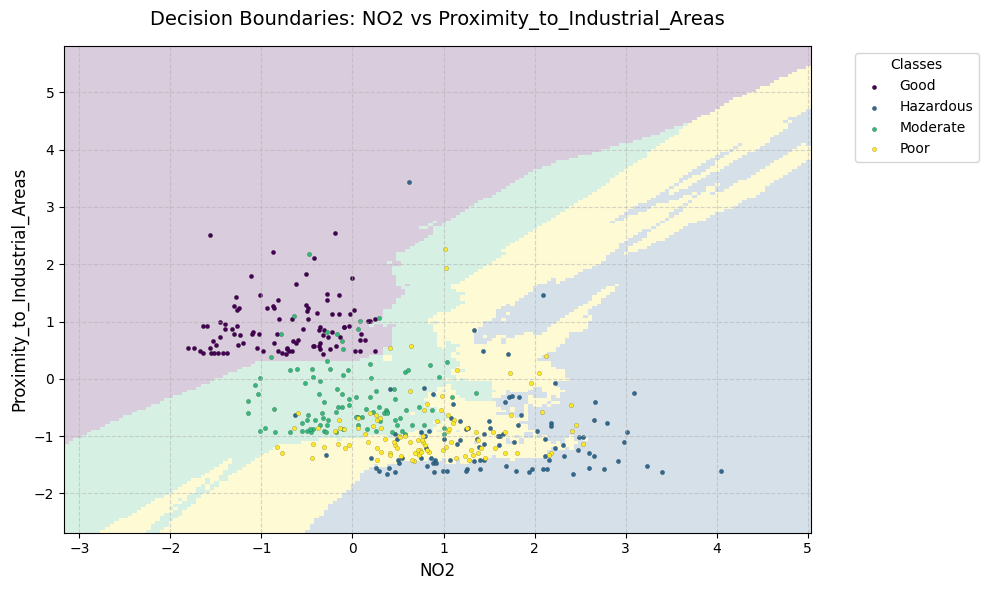

In [269]:
# 2D 2D 2D 2D
# Plot decision map 2D
if len(attributes) == 2:
    plot_decision_map(training_data, attributes, k, p, grid_step)
elif len(attributes) == 3:
    print("3D plot")
    # Plot decision from 3 angles
    training_data_01 = [[row[0], row[1], row[-1]] for row in training_data]
    training_data_12 = [[row[1], row[2], row[-1]] for row in training_data]
    training_data_02 = [[row[0], row[2], row[-1]] for row in training_data]
    plot_decision_map(training_data_01, attributes[:2], k, p, grid_step)
    plot_decision_map(training_data_12, attributes[1:], k, p, grid_step)
    plot_decision_map(training_data_02, [attributes[0], attributes[2]], k, p, grid_step)